`TTbarResCoffeaOutputs` Notebook to produce Coffea output files for an all hadronic $t\bar{t}$ analysis, should one choose not to run the .py script with condor.  The outputs will be found in the corresponding **CoffeaOutputs** directory.

In [41]:
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 
import os

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
if os.path.isfile(os.environ['X509_USER_PROXY']): pass
else: print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'



In [42]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt

# from lpcjobqueue import LPCCondorCluster

### Import processor

In [43]:
from CoffeaJERCProcessor import Processor

In [44]:
# xrootdstr = 'root://cmsxrootd.fnal.gov/'
xrootdstr = 'root://cms-xrd-global.cern.ch/'

rootfiles = open('dataset.txt').read().split()

fileslist = [xrootdstr + file for file in rootfiles]

#For testing
fileslist = [fileslist[0]]
fileslist = [xrootdstr + 
            '/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']


In [45]:
fileslist

['root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']

In [46]:
UsingDaskExecutor = False

if(UsingDaskExecutor):

        cluster = LPCCondorCluster()
        cluster.adapt(minimum=1, maximum=10)
        client = Client(cluster)
        client.upload_file('CoffeaJERCProcessor.py')
        
        client

In [47]:
import ROOT as R

In [48]:
R.TFile.Open(fileslist[0])

In [9]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 10] # [chunksize, maxchunks]

# xrootdstr = 'root://cmsxrootd.fnal.gov/'
# files = [xrootdstr + "/store/mc/RunIISummer19UL17NanoAOD/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/JMECustomTuples_106X_mc2017_realistic_v6-v1/280000/0F7E67F1-5FCB-EC4B-A0B3-E0E9B98AFC43.root"]
# files = ['JMECustomTuples_106X_mc2017_realistic_v6-v1.root']

filesets = {'QCD': fileslist}

for name,files in filesets.items(): 
    print(f"Processing name = {name}, files = {files} ")
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':False,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':False,
                                              'schema': NanoAODSchema, #BaseSchema
#                                               'workers': 2
                                          },
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])

elapsed = time.time() - tstart
outputs_unweighted[name] = output
print(output)
util.save(output, 'CoffeaJERCOutputs_binned.coffea')


outputs_unweighted[name] = output
print(name + ' unweighted output loaded')
elapsed = time.time() - tstart
print('Elapsed time = ', elapsed)

Processing name = QCD, files = ['root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root'] 
dict_keys(['Summer19UL18_V5_MC_L1FastJet_AK4PFchs'])
['Summer19UL18_V5_MC_L1FastJet_AK4PFchs']



Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

{'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fde0c8958b0>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fddefc70a30>, 'jetpt': <Hist (dataset,pt) instance at 0x7fddefc70df0>, 'jeteta': <Hist (dataset,jeteta) instance at 0x7fddefc70a00>, 'jetphi': <Hist (dataset,jetphi) instance at 0x7fddefc70d90>, 'cutflow': defaultdict_accumulator(<class 'int'>, {})}
QCD unweighted output loaded


### Load coffea output file

In [49]:
# output = util.load('CoffeaJERCOutputs_19928000events.coffea')
output = util.load('CoffeaJERCOutputs_binned.coffea')

In [50]:
output

{'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fddde4dfe20>,
 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fde0d5edf10>,
 'jetpt': <Hist (dataset,pt) instance at 0x7fde0d5ed460>,
 'jeteta': <Hist (dataset,jeteta) instance at 0x7fde0d5edc10>,
 'jetphi': <Hist (dataset,jetphi) instance at 0x7fde0d5ed730>,
 'cutflow': defaultdict_accumulator(int, {})}

In [51]:
# define gaussian function
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [52]:
ptbins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20, 23, 27, 30, 35, 40, 45, 57, 72, 90, 120, 
        150, 200, 300, 400, 550, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000 ]





In [53]:
etabins =   [-4.889,  -4.716,  -4.538,  -4.363,  -4.191,  -4.013,  -3.839,  -3.664,  -3.489,
           -3.314,  -3.139,  -2.964,  -2.853,  -2.65,  -2.5,  -2.322,  -2.172,  -2.043,  -1.93,  -1.83,
           -1.74,  -1.653,  -1.566,  -1.479,  -1.392,  -1.305,  -1.218,  -1.131,  -1.044,  -0.957,  -0.879,
           -0.783,  -0.696,  -0.609,  -0.522,  -0.435,  -0.348,  -0.261,  -0.174,  -0.087,  0,  0.087,  0.174,
           0.261,  0.348,  0.435,  0.522,  0.609,  0.696,  0.783,  0.879,  0.957,  1.044,  1.131,  1.218,
           1.305,  1.392,  1.479,  1.566,  1.653,  1.74,  1.83,  1.93,  2.043,  2.172,  2.322,  2.5,  2.65,
           2.853,  2.964,  3.139,  3.314,  3.489,  3.664,  3.839,  4.013,  4.191,  4.363,  4.538,  4.716,
           4.889, ]#5.191 ]

In [54]:
jetpt_length = len(output['jetpt'].axis('pt')[1:-1])
jeteta_length = len(output['jeteta'].axis('jeteta')[1:-1])
jeteta_length = len(etabins)

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
idx = []

In [55]:
for k in range(jeteta_length-1):
    print(hist.Interval(etabins[k], etabins[k+1]))
print()    
for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
    print(etaBin)

[-4.889, -4.716)
[-4.716, -4.538)
[-4.538, -4.363)
[-4.363, -4.191)
[-4.191, -4.013)
[-4.013, -3.839)
[-3.839, -3.664)
[-3.664, -3.489)
[-3.489, -3.314)
[-3.314, -3.139)
[-3.139, -2.964)
[-2.964, -2.853)
[-2.853, -2.65)
[-2.65, -2.5)
[-2.5, -2.322)
[-2.322, -2.172)
[-2.172, -2.043)
[-2.043, -1.93)
[-1.93, -1.83)
[-1.83, -1.74)
[-1.74, -1.653)
[-1.653, -1.566)
[-1.566, -1.479)
[-1.479, -1.392)
[-1.392, -1.305)
[-1.305, -1.218)
[-1.218, -1.131)
[-1.131, -1.044)
[-1.044, -0.957)
[-0.957, -0.879)
[-0.879, -0.783)
[-0.783, -0.696)
[-0.696, -0.609)
[-0.609, -0.522)
[-0.522, -0.435)
[-0.435, -0.348)
[-0.348, -0.261)
[-0.261, -0.174)
[-0.174, -0.087)
[-0.087, 0)
[0, 0.087)
[0.087, 0.174)
[0.174, 0.261)
[0.261, 0.348)
[0.348, 0.435)
[0.435, 0.522)
[0.522, 0.609)
[0.609, 0.696)
[0.696, 0.783)
[0.783, 0.879)
[0.879, 0.957)
[0.957, 1.044)
[1.044, 1.131)
[1.131, 1.218)
[1.218, 1.305)
[1.305, 1.392)
[1.392, 1.479)
[1.479, 1.566)
[1.566, 1.653)
[1.653, 1.74)
[1.74, 1.83)
[1.83, 1.93)
[1.93, 2.043)
[2

In [20]:
xvals = output['ptresponse'].axis('ptresponse').centers()
f_xvals = np.linspace(0,5,5001)

# mean = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# median = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# width = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# idx = []

j = 0

# for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1]):
    
for i in range(len(ptbins)-1):
        
    ptBin = hist.Interval(ptbins[i], ptbins[i+1])
    print('pt bin '+str(ptBin))
    
    if not 'inf' in str(ptBin):
        pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
    else:
        pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
        pt_string = pt_string.replace('.0','').replace('-infto','0to')
    
#     for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
    for k in range(len(etabins)-1):
        
        etaBin = hist.Interval(etabins[k], etabins[k+1])
        
    
        
        eta_string = '_eta'+str(etaBin.lo)+'to'+str(etaBin.hi)
        eta_string = eta_string.replace('.','')

        
        
        histo = output['ptresponse'].integrate('jeteta', etaBin).integrate('pt', ptBin)
        
        histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

        yvals = histo.values()[('QCD',)]
        
        
        
        try:
            p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        except:
            continue

        
        fgaus = gauss(f_xvals, *p)
        
#         median[i,k] = f_xvals[fgaus == np.max(fgaus)]
        median[i,k] = np.median(histvals)
        mean[i,k] = p[1]
        width[i,k] = p[2]
        idx.append(i)
        
        
        
        

        
        
#         h = np.max(histo.values()[('QCD',)])
#         ax = hist.plot1d(histo, overlay='dataset')
# #         plt.plot(f_xvals, fgaus)
#         plt.text(4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
#         plt.text(4,0.7*h,'Median {0:0.2f}'.format(np.median(histvals)))
#         plt.text(4,0.65*h,'Width {0:0.2f}'.format(p[2]))


#         plt.savefig('ptResponse'+pt_string+eta_string+'.png')
#         plt.show()
        


pt bin [1, 2)
pt bin [2, 3)
pt bin [3, 4)
pt bin [4, 5)
pt bin [5, 6)
pt bin [6, 7)
pt bin [7, 8)
pt bin [8, 9)
pt bin [9, 10)
pt bin [10, 11)
pt bin [11, 12)
pt bin [12, 13)
pt bin [13, 14)
pt bin [14, 15)
pt bin [15, 17)
pt bin [17, 20)
pt bin [20, 23)
pt bin [23, 27)
pt bin [27, 30)
pt bin [30, 35)
pt bin [35, 40)
pt bin [40, 45)
pt bin [45, 57)
pt bin [57, 72)
pt bin [72, 90)
pt bin [90, 120)
pt bin [120, 150)
pt bin [150, 200)
pt bin [200, 300)
pt bin [300, 400)
pt bin [400, 550)
pt bin [550, 750)
pt bin [750, 1000)
pt bin [1000, 1500)
pt bin [1500, 2000)
pt bin [2000, 2500)
pt bin [2500, 3000)
pt bin [3000, 3500)
pt bin [3500, 4000)
pt bin [4000, 4500)
pt bin [4500, 5000)
pt bin [5000, 10000)


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


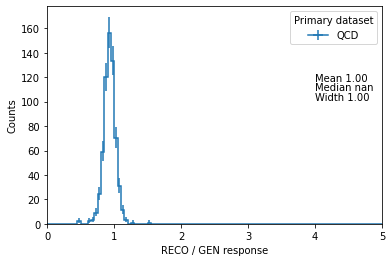

In [23]:
h = np.max(histo.values()[('QCD',)])
ax = hist.plot1d(histo, overlay='dataset')
#         plt.plot(f_xvals, fgaus)
plt.savefig('ptResponse'+pt_string+eta_string+'.png')
plt.text(4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
plt.text(4,0.7*h,'Median {0:0.2f}'.format(np.median(histvals)))
plt.text(4,0.65*h,'Width {0:0.2f}'.format(p[2]))

plt.show()

In [61]:
14000/h

89.74358974358974

In [25]:
np.max(histo.values()[('QCD',)])

156.0

In [26]:
arr = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

In [27]:
np.array(histo.values()[('QCD',)],dtype='int')

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   2,
         3,   9,  24,  59, 120, 156, 133,  70,  31,  11,   3,   0,   1,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [63]:
data

{'[1, 2)': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 '[2, 3)': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 '[3, 4)': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.

In [64]:
output['jetpt'].axis('pt')[1:-1]

[<Interval ([1, 2)) instance at 0x7fde0d366a30>,
 <Interval ([2, 3)) instance at 0x7fde0cf614c0>,
 <Interval ([3, 4)) instance at 0x7fde0cf61a00>,
 <Interval ([4, 5)) instance at 0x7fde0cf61d00>,
 <Interval ([5, 6)) instance at 0x7fde0cf61370>,
 <Interval ([6, 7)) instance at 0x7fde0cf61d30>,
 <Interval ([7, 8)) instance at 0x7fde0cf61ee0>,
 <Interval ([8, 9)) instance at 0x7fde0cf61640>,
 <Interval ([9, 10)) instance at 0x7fde0cf61460>,
 <Interval ([10, 11)) instance at 0x7fde0cf61f40>,
 <Interval ([11, 12)) instance at 0x7fde0cf61e80>,
 <Interval ([12, 13)) instance at 0x7fde0cf61a60>,
 <Interval ([13, 14)) instance at 0x7fde0d30a640>,
 <Interval ([14, 15)) instance at 0x7fde0d30a2b0>,
 <Interval ([15, 17)) instance at 0x7fde0d30aa30>,
 <Interval ([17, 20)) instance at 0x7fde0d30a6d0>,
 <Interval ([20, 23)) instance at 0x7fde0d30a0d0>,
 <Interval ([23, 27)) instance at 0x7fde0d30a280>,
 <Interval ([27, 30)) instance at 0x7fde0d30a4c0>,
 <Interval ([30, 35)) instance at 0x7fde0d30afd0

In [28]:
data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
# data = {str(ptBin):mean[i] for i, ptBin in enumerate(ptbins)}

data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
# data['etaBins'] = [str(etaBin) for etaBin in etabins]

df = pd.DataFrame(data=data)
df = df.set_index('etaBins')
df.to_csv('EtaBinsvsPtBinsMean.csv')

ValueError: arrays must all be same length

In [ ]:
data_width = {str(ptBin):width[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
# data_width = {str(ptBin):width[i] for i, ptBin in enumerate(ptbins)}

data_width['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
# data_width['etaBins'] = [str(etaBin) for etaBin in etabins]

df_width = pd.DataFrame(data=data_width)
df_width = df_width.set_index('etaBins')
df_width.to_csv('EtaBinsvsPtBinsWidth.csv')

In [ ]:
data_median = {str(ptBin):median[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
# data_median = {str(ptBin):median[i] for i, ptBin in enumerate(ptbins)}

data_median['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
# data_median['etaBins'] = [str(etaBin) for etaBin in etabins]

df_median = pd.DataFrame(data=data_median)
df_median = df_median.set_index('etaBins')
df_median.to_csv('EtaBinsvsPtBinsMedian.csv')

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

In [ ]:
df

In [ ]:
# df[pt bin][eta bin]

ptBin = '300'
etaBin = '0.783'

print('mean   =', np.round(df[ptBin][etaBin],3))
print('median =', np.round(df_median[ptBin][etaBin],3))
print('width  =', np.round(df_width[ptBin][etaBin],3))

In [ ]:
# df[pt bin][eta bin]

ptBin = '300'
etaBin = '0.783'

print('mean   =', df[ptBin][etaBin])
print('median =', df_median[ptBin][etaBin])
print('width  =', df_width[ptBin][etaBin])

### Read csv


 

format for example $ 20 \text{ GeV} < p_T < 25 \text{ GeV} $ and $ 3.5 < \eta < 4.0 $


```
df = pd.read_csv('EtaBinsvsPtBinsMean.csv).set_index('etaBins')
ptBin='[20, 25)'
etaBin='[3.5, 4)'
mean = df[ptBin][etaBin]
```




In [29]:
df_csv = pd.read_csv('EtaBinsvsPtBinsMean.csv').set_index('etaBins')

In [30]:
df_csv

,1,2,3,4,5,6,7,8,9,10,...,1000,1500,2000,2500,3000,3500,4000,4500,5000,10000
etaBins,,,,,,,,,,,,,,,,,,,,,
-4.889,1.0,1.0,1.919447,0.847434,0.819680,0.721227,0.726899,0.643112,0.666441,0.584961,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.716,1.0,1.0,0.788019,0.968363,0.896201,0.887233,0.770147,0.779571,0.773938,0.754217,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.538,1.0,1.0,0.775156,0.985856,0.906369,0.864158,0.836403,0.844416,0.822184,0.785098,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.363,1.0,1.0,1.048326,1.070429,0.936256,0.955706,0.898855,0.888521,0.850644,0.833098,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.191,1.0,1.0,1.550000,0.934685,0.974771,0.915665,0.859842,0.868492,0.874355,0.863439,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.191,1.0,1.0,1.203316,1.119529,0.940703,0.922488,0.878131,0.879070,0.873213,0.837680,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4.363,1.0,1.0,1.035349,0.702561,0.837196,0.934042,0.827903,0.836206,0.812478,0.806183,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4.538,1.0,1.0,1.649419,1.000351,0.876464,0.850328,0.837396,0.770957,0.764595,0.761215,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [33]:
df_median

NameError: name 'df_median' is not defined

In [32]:
eff = np.random.rand(10,10)
ptbins = np.random.randint(9, size=10)
etabins = np.random.randint(9, size=10)